In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#path = "../../../Google Drive/Data_science/NYU/Machine Learning/ML Project (Collisions)/" #Joe
path = "../../../../Google Drive/ML Project (Collisions)/" # Joyce
# path = "" # Lucas

In [3]:
df = pd.read_csv(path + "NYPD_Motor_Vehicle_Collisions.csv", parse_dates=[['DATE', 'TIME']], infer_datetime_format=True)

In [4]:
df['DATE_TIME'] = pd.to_numeric(df['DATE_TIME'])

Loop through the directory

In [5]:
datasets = {}

for file in os.listdir(path+"data_for_joining/"):
    if file.endswith(".pkl"):
        with open(os.path.join(path+"data_for_joining/", file), 'rb') as pkl_file:
            datasets[file.strip(".pkl")] = pickle.load(pkl_file, encoding='latin1')

In [6]:
for key, value in datasets.items() :
    print (key)
    if "traffic" in key:
        datasets[key].name = datasets[key].name + '_' + key.split('_')[-1]
    df = df.join(datasets[key], on='UNIQUE KEY', how='left', rsuffix="_"+key)

traffic_joined_0.003
weather_joined_utm
ights_complaints_merged
daylight_joined
traffic_joined_0.03
traffic_joined_0.005
injury_avgs
311_joined
self
traffic_joined_0.1
Bank_Holidays
traffic_joined_0.3
traffic_joined_0.002
subway_joined
traffic_joined_0.06


In [7]:
renamed_columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    
df.columns = renamed_columns

In [8]:
df.ix[df.longitude[df.longitude < -100].index,'longitude'] = np.nan

In [9]:
df['rise_time'] = df.rise_time.dt.hour*60 + df.rise_time.dt.minute
df['set_time'] = df.set_time.dt.hour*60 + df.set_time.dt.minute

(0, 10000)

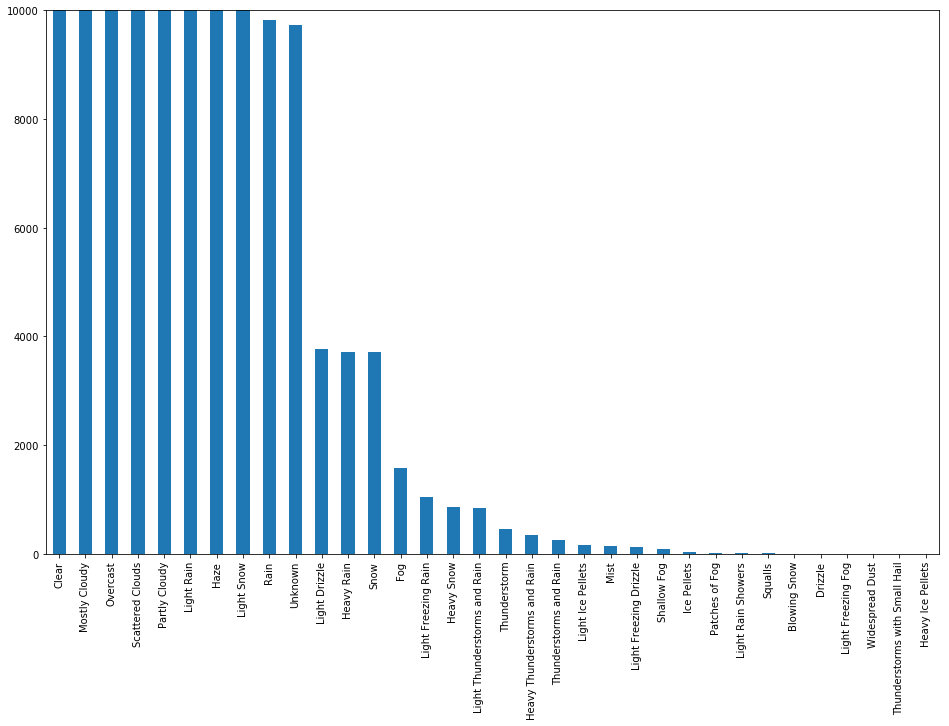

In [10]:
plt.figure(figsize=(16,10))
df['conditions'].value_counts().plot(kind='bar')
plt.ylim([0, 10000])

In [11]:
remap_weather = {'Heavy Snow': 'Snow',
                'Light Freezing Rain': 'Light Rain',
                'Heavy Thunderstorms and Rain': 'Thunderstorms and Rain',
                'Light Thunderstorms and Rain': 'Thunderstorms and Rain',
                'Light Ice Pellets': 'Ice Pellets',
                'Heavy Ice Pellets': 'Ice Pellets',
                'Thunderstorms with Small Hail': 'Thunderstorms and Rain',
                'Shallow Fog': 'Fog',
                'Light Freezing Fog': 'Fog',
                'Mist': 'Fog',
                'Blowing Snow': 'Snow',
                'Drizzle': 'Light Rain',
                'Widespread Dust': 'Haze',
                'Squalls': np.nan,
                'Unknown': np.nan,
                'Light Drizzle': 'Light Rain',
                'Light Freezing Drizzle': 'Light Rain',
                'Patches of Fog': 'Fog',
                'Light Rain Showers': 'Light Rain',
                }

df['conditions'] = df['conditions'].replace(remap_weather)

(0, 10000)

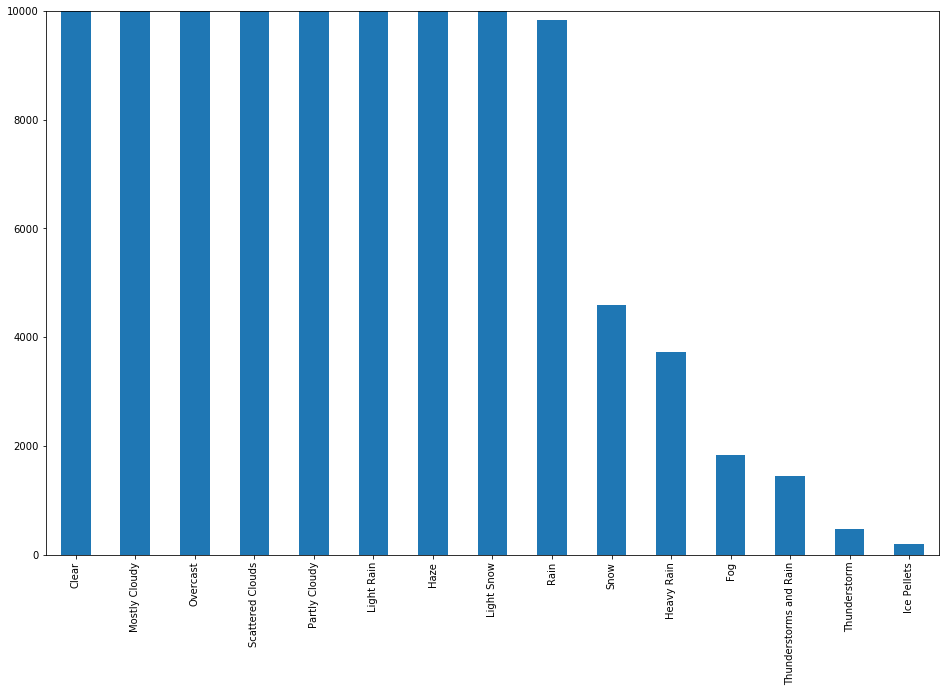

In [12]:
plt.figure(figsize=(16,10))
df['conditions'].value_counts().plot(kind='bar')
plt.ylim([0, 10000])

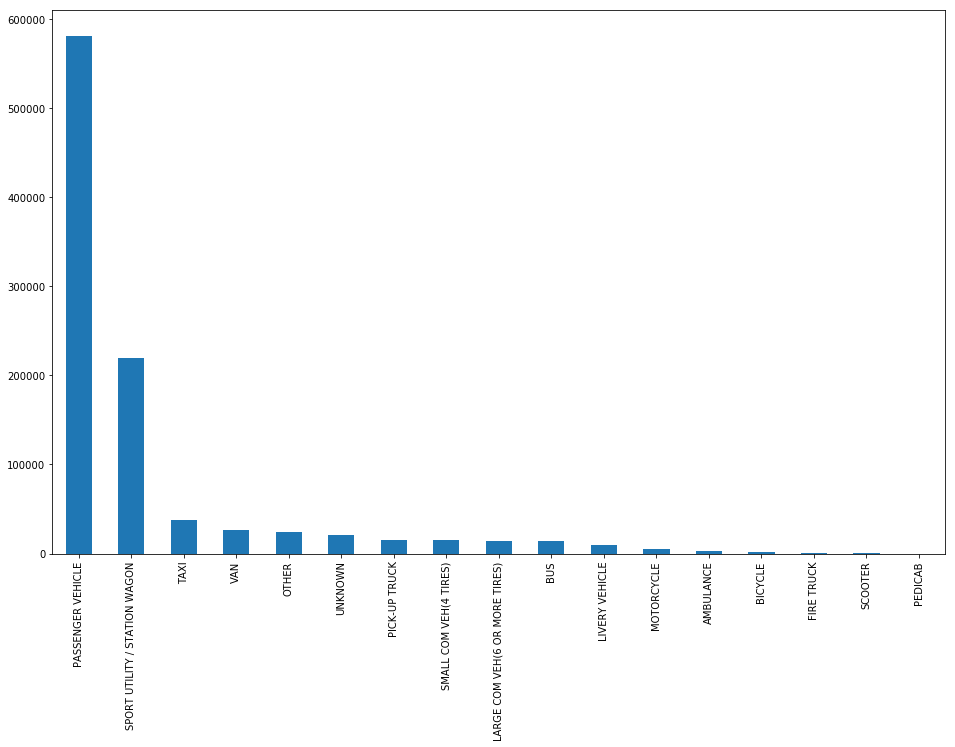

In [13]:
plt.figure(figsize=(16,10))
df['vehicle_type_code_1'].value_counts().plot(kind='bar')

In [14]:
remap_vehicle = {'TAXI': 'SMALL COM VEH(4 TIRES)',
                'BUS': 'LARGE VEHICLE',
                'SCOOTER': 'MOTORCYCLE',
                'LIVERY VEHICLE': 'SMALL COM VEH(4 TIRES)',
                'VAN': 'MEDIUM VEHICLE',
                'PEDICAB': 'BICYCLE',
                'PICK-UP TRUCK': 'MEDIUM VEHICLE',
                'SPORT UTILITY / STATION WAGON': 'MEDIUM VEHICLE',
                'LARGE COM VEH(6 OR MORE TIRES)': 'LARGE VEHICLE',
                'FIRE TRUCK': 'LARGE VEHICLE',
                }

In [15]:
for column in ['vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5']:
    df[column] = df[column].replace(remap_vehicle)

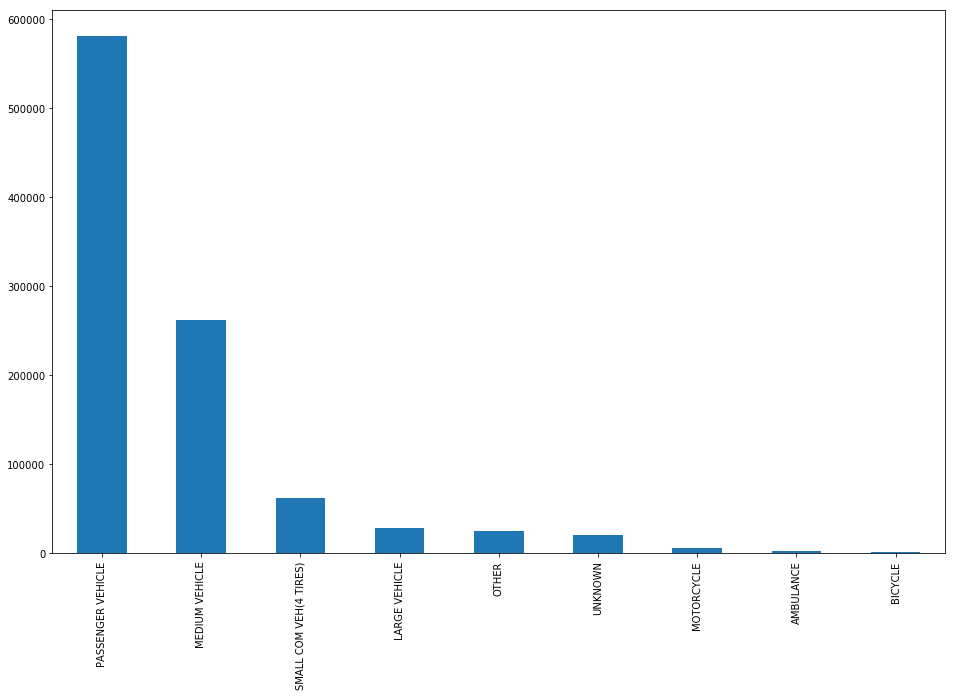

In [16]:
plt.figure(figsize=(16,10))
df['vehicle_type_code_1'].value_counts().plot(kind='bar')

In [17]:
df = df.reset_index()
df = df.drop(['index'], axis=1)

In [21]:
floats = ['latitude', 'longitude','temperature', 'heat_index', 'dew_point', 'humidity', 'pressure',\
          'visibility', 'wind_speed', 'gust_speed', 'precip', 'zip_code']

In [22]:
for column in floats:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [23]:
with open(path+"data_for_training/v2/predrop_collisions.pkl", 'wb') as outfile:
    pickle.dump(df, outfile)

In [24]:
drop_columns = ['index', 'location', 'unique_key', 'on_street_name', 'cross_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
        'vehicle_type_code_1', 'vehicle_type_code_2', 'vehicle_type_code_3', 
        'vehicle_type_code_4', 'vehicle_type_code_5']

In [25]:
df = df.drop(drop_columns, axis=1)

In [26]:
def fill_nas(df):
    
    for column in df:
        if np.sum(df[column].isnull()) > 0:
            df[column+'_nan'] = df[column].isnull()

            if column == 'zip_code':
                df[column].fillna(df[column].mode()[0], inplace=True)
            elif column in df._get_numeric_data().columns.values:
                df[column].fillna(df[column].mean(), inplace=True)
                
    return df
            
df = fill_nas(df)

In [27]:
onehotdf = pd.get_dummies(df, columns=['borough', 'wind_dir', 'conditions'])

In [28]:
renamed_columns = [x.lower().replace(' ', '_') for x in onehotdf.columns.values]
    
onehotdf.columns = renamed_columns

In [29]:
with open(path+"data_for_training/v2/collisions_1hot.pkl", 'wb') as outfile:
    pickle.dump(onehotdf, outfile)

In [30]:
with open(path+"data_for_training/v2/collisions_no1hot.pkl", 'wb') as outfile:
    pickle.dump(df, outfile)

In [31]:
df

,date_time,borough,zip_code,latitude,longitude,uber_count_0.003,temperature,heat_index,dew_point,humidity,...,chronic_speeding_0.3_bin_nan,chronic_stoplight_violation_0.3_bin_nan,congestion/gridlock_0.3_bin_nan,drag_racing_0.3_bin_nan,truck_route_violation_0.3_bin_nan,uber_count_0.1_nan,uber_count_0.3_nan,uber_count_0.002_nan,dist_to_closest_subway_nan,uber_count_0.06_nan
0,1488893820000000000,BROOKLYN,11205.0,40.697254,-73.961830,3.000000,51.1,44.947843,46.0,83.0,...,False,False,False,False,False,False,False,False,False,False
1,1488893880000000000,NaN,11207.0,40.795370,-73.921974,1.000000,51.1,44.947843,46.0,83.0,...,False,False,False,False,False,False,False,False,False,False
2,1488894000000000000,NaN,11207.0,40.758644,-73.981346,128.000000,51.1,44.947843,46.0,83.0,...,False,False,False,False,False,False,False,False,False,False
3,1488894600000000000,BROOKLYN,11234.0,40.632847,-73.928375,0.000000,46.9,44.947843,44.1,90.0,...,False,False,False,False,False,False,False,False,False,False
4,1440529200000000000,NaN,11207.0,40.732941,-73.920382,0.000000,84.9,83.600000,55.0,36.0,...,False,False,False,False,False,False,False,False,False,False
5,1343428500000000000,NaN,11207.0,40.721841,-73.921024,16.665826,81.0,83.000000,66.0,60.0,...,True,True,True,True,True,True,True,True,True,True
6,1400287500000000000,NaN,11207.0,40.721841,-73.921024,16.665826,59.0,44.947843,55.0,87.0,...,True,True,True,True,True,True,True,True,True,True
7,1488894600000000000,QUEENS,11355.0,40.746902,-73.834694,0.000000,50.0,44.947843,45.0,83.0,...,False,False,False,False,False,False,False,False,False,False
8,1488895200000000000,BRONX,10461.0,40.842030,-73.849560,0.000000,51.1,44.947843,44.1,77.0,...,False,False,False,False,False,False,False,False,False,False
9,1488895200000000000,BROOKLYN,11230.0,40.624878,-73.964180,0.000000,46.9,44.947843,43.0,86.0,...,False,False,False,False,False,False,False,False,False,False


In [32]:
view_date = pd.to_datetime(df['date_time'])

train_indices = (0, np.sum(view_date < datetime.date(2015,9,12))-1)
val_indices = (train_indices[1]+1,\
               train_indices[1] + \
               np.sum((view_date >= datetime.date(2015,9,12)) & (view_date < datetime.date(2016,7,31))))
test_indices = (val_indices[1]+1,\
               val_indices[1] + np.sum(view_date >= datetime.date(2016,7,31)))

In [33]:
train = df.iloc[train_indices[0]:train_indices[1]]
val = df.iloc[val_indices[0]:val_indices[1]]
test = df.iloc[test_indices[0]:test_indices[1]]

In [34]:
train_count = np.sum(train['num_bicycle'] > 0)
val_count = np.sum(val['num_bicycle'] > 0)
test_count = np.sum(test['num_bicycle'] > 0)
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

67.48, 20.05, 12.47


In [35]:
train_count = np.sum((train['num_vehicles'] == 1) & (train['num_bicycle'] == 0))
val_count = np.sum((val['num_vehicles'] == 1) & (val['num_bicycle'] == 0))
test_count = np.sum((test['num_vehicles'] == 1) & (test['num_bicycle'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

70.74, 15.02, 14.24


In [36]:
train_count = np.sum((train['num_vehicles'] == 0))
val_count = np.sum((val['num_vehicles'] == 0))
test_count = np.sum((test['num_vehicles'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

95.51, 1.58, 2.92


In [37]:
train_count = np.sum((train['num_vehicles'] > 1) & (train['num_bicycle'] == 0))
val_count = np.sum((val['num_vehicles'] > 1) & (val['num_bicycle'] == 0))
test_count = np.sum((test['num_vehicles'] > 1) & (test['num_bicycle'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

65.42, 20.76, 13.82


In [38]:
onehotdf.columns.values

array(['date_time', 'zip_code', 'latitude', 'longitude',
       'uber_count_0.003', 'temperature', 'heat_index', 'dew_point',
       'humidity', 'pressure', 'visibility', 'wind_speed', 'gust_speed',
       'precip', 'rain', 'thunderstorm', 'snow', 'fog',
       'lights_complaints_0.03', 'lights_complaints_0.001',
       'lights_complaints_0.06', 'rise_time', 'set_time', 'sun_out',
       'uber_count_0.03', 'uber_count_0.005', 'injured_or_killed_-_0.01',
       'injured_or_killed_-_0.03', 'injured_or_killed_-_0.06',
       'injured_or_killed_-_0.1', 'chronic_speeding_0.06_bin',
       'chronic_stoplight_violation_0.06_bin',
       'congestion/gridlock_0.06_bin', 'drag_racing_0.06_bin',
       'truck_route_violation_0.06_bin', 'chronic_speeding_0.1_bin',
       'chronic_stoplight_violation_0.1_bin',
       'congestion/gridlock_0.1_bin', 'drag_racing_0.1_bin',
       'truck_route_violation_0.1_bin', 'chronic_speeding_0.3_bin',
       'chronic_stoplight_violation_0.3_bin',
       'congesti